# Machine Learning Diabetes Classification

## Read csv and perform basic data cleaning

In [1]:
# Install zipfile36 if you haven't already
# !pip install zipfile36

In [2]:
# Import our dependencies
import pandas as pd
import numpy as np
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

# SQL
from sqlalchemy import create_engine
import sqlite3 as sql

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [3]:
# Create dataframe
z = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip')
myzip = ZipFile(BytesIO(z.read())).extract('dataset_diabetes/diabetic_data.csv')
df = pd.read_csv(myzip)
df.head(5)
target = ['A1Cresult']

In [4]:
# Drop the non-beneficial ID columns, 'encounter_id' and 'patient_nbr'
df = df.drop(['patient_nbr'],1)

# Drop mostly empty columns, 'weight', 'payer_code', 'max_glu_serum', and 'medical_specialty'
df = df.drop(['weight', 'payer_code', 'max_glu_serum', 'medical_specialty', ],1)

# Replace '?' values to nulls
df.replace({'?': np.nan}, inplace=True)

# Replace 'None' values to nulls
df.replace({'None': np.nan}, inplace=True)

# Drop the null rows
df = df.dropna()

/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_11427/4207756282.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['patient_nbr'],1)
/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_11427/4207756282.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['weight', 'payer_code', 'max_glu_serum', 'medical_specialty', ],1)


In [5]:
# Convert the target column values to normal and high based on their values
x = {'Norm': 'normal'}   
df = df.replace(x)
x = dict.fromkeys(['>7', '>8'], 'high')    
df = df.replace(x)
df.reset_index(inplace=True, drop=True)

In [6]:
# Determine the number of unique values in each column.
df.nunique()

encounter_id                16193
race                            5
gender                          2
age                            10
admission_type_id               8
discharge_disposition_id       21
admission_source_id            15
time_in_hospital               14
num_lab_procedures            114
num_procedures                  7
num_medications                67
number_outpatient              24
number_emergency               19
number_inpatient               18
diag_1                        490
diag_2                        486
diag_3                        539
number_diagnoses               12
A1Cresult                       2
metformin                       4
repaglinide                     4
nateglinide                     4
chlorpropamide                  2
glimepiride                     4
acetohexamide                   1
glipizide                       4
glyburide                       4
tolbutamide                     2
pioglitazone                    4
rosiglitazone 

In [7]:
# Drop columns with only 1 value
df = df.drop(['acetohexamide', 'troglitazone', 'examide', 'citoglipton','glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'],1)
df.nunique()

/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_11427/190791345.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['acetohexamide', 'troglitazone', 'examide', 'citoglipton','glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'],1)


encounter_id                16193
race                            5
gender                          2
age                            10
admission_type_id               8
discharge_disposition_id       21
admission_source_id            15
time_in_hospital               14
num_lab_procedures            114
num_procedures                  7
num_medications                67
number_outpatient              24
number_emergency               19
number_inpatient               18
diag_1                        490
diag_2                        486
diag_3                        539
number_diagnoses               12
A1Cresult                       2
metformin                       4
repaglinide                     4
nateglinide                     4
chlorpropamide                  2
glimepiride                     4
glipizide                       4
glyburide                       4
tolbutamide                     2
pioglitazone                    4
rosiglitazone                   4
acarbose      

In [8]:
# Drop variables with outliers 
df = df.drop(['number_inpatient', 'number_outpatient','number_emergency'],1)
df.nunique()

/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_11427/3814313382.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['number_inpatient', 'number_outpatient','number_emergency'],1)


encounter_id                16193
race                            5
gender                          2
age                            10
admission_type_id               8
discharge_disposition_id       21
admission_source_id            15
time_in_hospital               14
num_lab_procedures            114
num_procedures                  7
num_medications                67
diag_1                        490
diag_2                        486
diag_3                        539
number_diagnoses               12
A1Cresult                       2
metformin                       4
repaglinide                     4
nateglinide                     4
chlorpropamide                  2
glimepiride                     4
glipizide                       4
glyburide                       4
tolbutamide                     2
pioglitazone                    4
rosiglitazone                   4
acarbose                        4
miglitol                        4
tolazamide                      3
insulin       

In [9]:
# Info on the data frame data types, non_null, etc. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16193 entries, 0 to 16192
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              16193 non-null  int64 
 1   race                      16193 non-null  object
 2   gender                    16193 non-null  object
 3   age                       16193 non-null  object
 4   admission_type_id         16193 non-null  int64 
 5   discharge_disposition_id  16193 non-null  int64 
 6   admission_source_id       16193 non-null  int64 
 7   time_in_hospital          16193 non-null  int64 
 8   num_lab_procedures        16193 non-null  int64 
 9   num_procedures            16193 non-null  int64 
 10  num_medications           16193 non-null  int64 
 11  diag_1                    16193 non-null  object
 12  diag_2                    16193 non-null  object
 13  diag_3                    16193 non-null  object
 14  number_diagnoses      

In [10]:
# Looking at dataframe 
df.head()

,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide-metformin,glipizide-metformin,change,diabetesMed,readmitted
0,236316,Caucasian,Male,[80-90),1,3,7,6,64,3,...,No,No,No,No,No,No,No,Ch,Yes,NO
1,955884,Caucasian,Female,[70-80),1,3,7,5,34,0,...,No,No,No,No,Up,No,No,Ch,Yes,>30
2,1257282,Other,Female,[50-60),1,1,7,2,53,0,...,No,No,No,No,Up,No,No,Ch,Yes,NO
3,1270524,Caucasian,Male,[60-70),1,2,7,1,59,0,...,No,No,No,No,Steady,No,No,No,Yes,NO
4,1455252,Caucasian,Female,[80-90),1,1,7,3,34,0,...,No,No,No,No,No,No,No,No,No,>30


In [11]:
# Generate our categorical variable list
df_cat = df.dtypes[df.dtypes == "object"].index.tolist()
df_cat

['race',
 'gender',
 'age',
 'diag_1',
 'diag_2',
 'diag_3',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'change',
 'diabetesMed',
 'readmitted']

In [12]:
# Check the number of unique values in each column
df[df_cat].nunique()

race                     5
gender                   2
age                     10
diag_1                 490
diag_2                 486
diag_3                 539
A1Cresult                2
metformin                4
repaglinide              4
nateglinide              4
chlorpropamide           2
glimepiride              4
glipizide                4
glyburide                4
tolbutamide              2
pioglitazone             4
rosiglitazone            4
acarbose                 4
miglitol                 4
tolazamide               3
insulin                  4
glyburide-metformin      4
glipizide-metformin      2
change                   2
diabetesMed              2
readmitted               3
dtype: int64

In [13]:
# Create SQLite engine using SQLAlechmey
engine = create_engine('sqlite:///diabetes_data.db', echo=False)
conn = engine.connect()
df.to_sql('diabetes', conn, index=False, if_exists='replace')

In [14]:
# Check dataset
pd.read_sql('SELECT * FROM diabetes LIMIT 10', conn)

,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide-metformin,glipizide-metformin,change,diabetesMed,readmitted
0,236316,Caucasian,Male,[80-90),1,3,7,6,64,3,...,No,No,No,No,No,No,No,Ch,Yes,NO
1,955884,Caucasian,Female,[70-80),1,3,7,5,34,0,...,No,No,No,No,Up,No,No,Ch,Yes,>30
2,1257282,Other,Female,[50-60),1,1,7,2,53,0,...,No,No,No,No,Up,No,No,Ch,Yes,NO
3,1270524,Caucasian,Male,[60-70),1,2,7,1,59,0,...,No,No,No,No,Steady,No,No,No,Yes,NO
4,1455252,Caucasian,Female,[80-90),1,1,7,3,34,0,...,No,No,No,No,No,No,No,No,No,>30
5,1810752,Caucasian,Male,[70-80),1,3,7,14,78,1,...,No,No,No,No,Up,No,No,Ch,Yes,<30
6,1881372,Caucasian,Male,[60-70),1,2,7,4,65,2,...,No,No,No,No,Steady,No,No,No,Yes,<30
7,1968528,Caucasian,Female,[70-80),6,25,1,10,56,2,...,No,No,No,No,Down,No,No,Ch,Yes,>30
8,2092362,Caucasian,Female,[70-80),6,25,7,11,88,1,...,No,No,No,No,Down,No,No,Ch,Yes,>30
9,2095932,AfricanAmerican,Female,[30-40),6,25,7,8,62,0,...,No,No,No,No,Steady,No,No,Ch,Yes,>30


In [15]:
# Create cleanup table
engine.execute('CREATE TABLE "cleaned_columns" ('
               'id BIGINT NOT NULL,'
               'diag_1c VARCHAR, '
               'diag_2c VARCHAR, '
               'diag_3c VARCHAR, '
               'PRIMARY KEY (id));')

In [16]:
# Insert columns into new table to clean
engine.execute('INSERT INTO "cleaned_columns" '
               'SELECT encounter_id AS id, '
               'CASE '
                   'WHEN (diag_1 BETWEEN 390 AND 459) OR (diag_1 = 785) THEN "circulatory" '
                   'WHEN (diag_1 BETWEEN 460 AND 519) OR (diag_1 = 786) THEN "respiratory" '
                   'WHEN (diag_1 BETWEEN 520 AND 579) OR (diag_1 = 787) THEN "digestive" '
                   'WHEN (diag_1 BETWEEN 250 AND 251) THEN "diabetes" '
                   'WHEN (diag_1 BETWEEN 800 AND 999) THEN "injury" '
                   'WHEN (diag_1 BETWEEN 710 AND 739) THEN "musculoskeletal" '
                   'WHEN (diag_1 BETWEEN 580 AND 629) OR (diag_1 = 788) THEN "genitourinary" '
                   'WHEN (diag_1 BETWEEN 140 AND 239) THEN "neoplasms" '
                   'ELSE "other" '
               'END AS diag_1c, '
               'CASE '
                   'WHEN (diag_2 BETWEEN 390 AND 459) OR (diag_2 = 785) THEN "circulatory" '
                   'WHEN (diag_2 BETWEEN 460 AND 519) OR (diag_2 = 786) THEN "respiratory" '
                   'WHEN (diag_2 BETWEEN 520 AND 579) OR (diag_2 = 787) THEN "digestive" '
                   'WHEN (diag_2 BETWEEN 250 AND 251) THEN "diabetes" '
                   'WHEN (diag_2 BETWEEN 800 AND 999) THEN "injury" '
                   'WHEN (diag_2 BETWEEN 710 AND 739) THEN "musculoskeletal" '
                   'WHEN (diag_2 BETWEEN 580 AND 629) OR (diag_2 = 788) THEN "genitourinary" '
                   'WHEN (diag_2 BETWEEN 140 AND 239) THEN "neoplasms" '
                   'ELSE "other" '
               'END AS diag_2c, '
               'CASE '
                   'WHEN (diag_3 BETWEEN 390 AND 459) OR (diag_3 = 785) THEN "circulatory" '
                   'WHEN (diag_3 BETWEEN 460 AND 519) OR (diag_3 = 786) THEN "respiratory" '
                   'WHEN (diag_3 BETWEEN 520 AND 579) OR (diag_3 = 787) THEN "digestive" '
                   'WHEN (diag_3 BETWEEN 250 AND 251) THEN "diabetes" '
                   'WHEN (diag_3 BETWEEN 800 AND 999) THEN "injury" '
                   'WHEN (diag_3 BETWEEN 710 AND 739) THEN "musculoskeletal" '
                   'WHEN (diag_3 BETWEEN 580 AND 629) OR (diag_3 = 788) THEN "genitourinary" '
                   'WHEN (diag_3 BETWEEN 140 AND 239) THEN "neoplasms" '
                   'ELSE "other" '
               'END AS diag_3c '
               'FROM diabetes;')

In [17]:
# Check data
pd.read_sql('SELECT * FROM cleaned_columns LIMIT 10', conn)

,id,diag_1c,diag_2c,diag_3c
0,236316,circulatory,circulatory,circulatory
1,955884,circulatory,circulatory,other
2,1257282,genitourinary,diabetes,circulatory
3,1270524,circulatory,circulatory,respiratory
4,1455252,circulatory,circulatory,circulatory
5,1810752,circulatory,diabetes,diabetes
6,1881372,circulatory,circulatory,respiratory
7,1968528,circulatory,circulatory,diabetes
8,2092362,diabetes,other,genitourinary
9,2095932,diabetes,circulatory,other


In [18]:
# Join diabetes and cleaned_columns tables
diabetes_df = pd.read_sql('SELECT * FROM diabetes JOIN cleaned_columns ON diabetes.encounter_id = cleaned_columns.id', conn)
diabetes_df 

,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,insulin,glyburide-metformin,glipizide-metformin,change,diabetesMed,readmitted,id,diag_1c,diag_2c,diag_3c
0,236316,Caucasian,Male,[80-90),1,3,7,6,64,3,...,No,No,No,Ch,Yes,NO,236316,circulatory,circulatory,circulatory
1,955884,Caucasian,Female,[70-80),1,3,7,5,34,0,...,Up,No,No,Ch,Yes,>30,955884,circulatory,circulatory,other
2,1257282,Other,Female,[50-60),1,1,7,2,53,0,...,Up,No,No,Ch,Yes,NO,1257282,genitourinary,diabetes,circulatory
3,1270524,Caucasian,Male,[60-70),1,2,7,1,59,0,...,Steady,No,No,No,Yes,NO,1270524,circulatory,circulatory,respiratory
4,1455252,Caucasian,Female,[80-90),1,1,7,3,34,0,...,No,No,No,No,No,>30,1455252,circulatory,circulatory,circulatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16188,443816024,Caucasian,Female,[70-80),3,6,1,3,27,1,...,Steady,No,No,Ch,Yes,NO,443816024,musculoskeletal,circulatory,diabetes
16189,443835140,Caucasian,Male,[70-80),3,6,1,13,77,6,...,Up,No,No,Ch,Yes,NO,443835140,circulatory,circulatory,respiratory
16190,443842016,Caucasian,Female,[70-80),1,1,7,9,50,2,...,Steady,No,No,Ch,Yes,>30,443842016,digestive,digestive,diabetes
16191,443842022,Other,Female,[40-50),1,1,7,14,73,6,...,Up,No,No,Ch,Yes,>30,443842022,genitourinary,genitourinary,respiratory


In [19]:
# Check Datatypes
diabetes_df.dtypes

encounter_id                 int64
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
tolazamide          

In [20]:
# View DataFrame
diabetes_df

,encounter_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,insulin,glyburide-metformin,glipizide-metformin,change,diabetesMed,readmitted,id,diag_1c,diag_2c,diag_3c
0,236316,Caucasian,Male,[80-90),1,3,7,6,64,3,...,No,No,No,Ch,Yes,NO,236316,circulatory,circulatory,circulatory
1,955884,Caucasian,Female,[70-80),1,3,7,5,34,0,...,Up,No,No,Ch,Yes,>30,955884,circulatory,circulatory,other
2,1257282,Other,Female,[50-60),1,1,7,2,53,0,...,Up,No,No,Ch,Yes,NO,1257282,genitourinary,diabetes,circulatory
3,1270524,Caucasian,Male,[60-70),1,2,7,1,59,0,...,Steady,No,No,No,Yes,NO,1270524,circulatory,circulatory,respiratory
4,1455252,Caucasian,Female,[80-90),1,1,7,3,34,0,...,No,No,No,No,No,>30,1455252,circulatory,circulatory,circulatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16188,443816024,Caucasian,Female,[70-80),3,6,1,3,27,1,...,Steady,No,No,Ch,Yes,NO,443816024,musculoskeletal,circulatory,diabetes
16189,443835140,Caucasian,Male,[70-80),3,6,1,13,77,6,...,Up,No,No,Ch,Yes,NO,443835140,circulatory,circulatory,respiratory
16190,443842016,Caucasian,Female,[70-80),1,1,7,9,50,2,...,Steady,No,No,Ch,Yes,>30,443842016,digestive,digestive,diabetes
16191,443842022,Other,Female,[40-50),1,1,7,14,73,6,...,Up,No,No,Ch,Yes,>30,443842022,genitourinary,genitourinary,respiratory


In [21]:
# Generate our categorical variable list
diabetes_df_cat = diabetes_df.dtypes[diabetes_df.dtypes == "object"].index.tolist()
diabetes_df_cat

['race',
 'gender',
 'age',
 'diag_1',
 'diag_2',
 'diag_3',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'change',
 'diabetesMed',
 'readmitted',
 'diag_1c',
 'diag_2c',
 'diag_3c']

In [22]:
# Drop the non-beneficial ID and diag columns, 'encounter_id', 'id', 'diag_1', 'diag_2', and 'diag_3'
diabetes_2_df = diabetes_df.drop(['encounter_id', 'id', 'diag_1', 'diag_2', 'diag_3'],1)

/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_11427/2165655525.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  diabetes_2_df = diabetes_df.drop(['encounter_id', 'id', 'diag_1', 'diag_2', 'diag_3'],1)


In [23]:
diabetes_2_df 

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,change,diabetesMed,readmitted,diag_1c,diag_2c,diag_3c
0,Caucasian,Male,[80-90),1,3,7,6,64,3,18,...,No,No,No,No,Ch,Yes,NO,circulatory,circulatory,circulatory
1,Caucasian,Female,[70-80),1,3,7,5,34,0,17,...,No,Up,No,No,Ch,Yes,>30,circulatory,circulatory,other
2,Other,Female,[50-60),1,1,7,2,53,0,6,...,No,Up,No,No,Ch,Yes,NO,genitourinary,diabetes,circulatory
3,Caucasian,Male,[60-70),1,2,7,1,59,0,12,...,No,Steady,No,No,No,Yes,NO,circulatory,circulatory,respiratory
4,Caucasian,Female,[80-90),1,1,7,3,34,0,11,...,No,No,No,No,No,No,>30,circulatory,circulatory,circulatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16188,Caucasian,Female,[70-80),3,6,1,3,27,1,29,...,No,Steady,No,No,Ch,Yes,NO,musculoskeletal,circulatory,diabetes
16189,Caucasian,Male,[70-80),3,6,1,13,77,6,65,...,No,Up,No,No,Ch,Yes,NO,circulatory,circulatory,respiratory
16190,Caucasian,Female,[70-80),1,1,7,9,50,2,33,...,No,Steady,No,No,Ch,Yes,>30,digestive,digestive,diabetes
16191,Other,Female,[40-50),1,1,7,14,73,6,26,...,No,Up,No,No,Ch,Yes,>30,genitourinary,genitourinary,respiratory


In [24]:
# Check data
diabetes_2_df.dtypes

race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_diagnoses             int64
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
tolazamide                  object
insulin                     object
glyburide-metformin         object
glipizide-metformin         object
change              

In [25]:
# Generate our categorical variable list
diabetes_2_df_cat = diabetes_2_df.dtypes[diabetes_2_df.dtypes == "object"].index.tolist()
diabetes_2_df_cat

['race',
 'gender',
 'age',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'change',
 'diabetesMed',
 'readmitted',
 'diag_1c',
 'diag_2c',
 'diag_3c']

In [26]:
# OneHot encode the categorical data
from sklearn.preprocessing import OneHotEncoder

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(diabetes_2_df[diabetes_2_df_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names_out(diabetes_2_df_cat)
encode_df.head()

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,age_[0-10),age_[10-20),age_[20-30),...,diag_2c_respiratory,diag_3c_circulatory,diag_3c_diabetes,diag_3c_digestive,diag_3c_genitourinary,diag_3c_injury,diag_3c_musculoskeletal,diag_3c_neoplasms,diag_3c_other,diag_3c_respiratory
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Merge one-hot encoded features and drop the originals
diabetes_2_df = diabetes_2_df.merge(encode_df,left_index=True, right_index=True)
diabetes_2_df = diabetes_2_df.drop(diabetes_2_df_cat,1)
diabetes_2_df.head()

/var/folders/xg/sj5cjcj55mdf6d5492q3c5m00000gn/T/ipykernel_11427/47016200.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  diabetes_2_df = diabetes_2_df.drop(diabetes_2_df_cat,1)


,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,race_AfricanAmerican,race_Asian,...,diag_2c_respiratory,diag_3c_circulatory,diag_3c_diabetes,diag_3c_digestive,diag_3c_genitourinary,diag_3c_injury,diag_3c_musculoskeletal,diag_3c_neoplasms,diag_3c_other,diag_3c_respiratory
0,1,3,7,6,64,3,18,7,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3,7,5,34,0,17,7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,1,7,2,53,0,6,3,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2,7,1,59,0,12,7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,1,7,3,34,0,11,8,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Running Random Forest 
# Remove target from features data
y = diabetes_2_df['A1Cresult_high']
X = diabetes_2_df

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [56]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 1.000


In [57]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = len(X_train_scaled[0])*3
hidden_nodes_layer2 = len(X_train_scaled[0])*2
hidden_nodes_layer3 = len(X_train_scaled[0])

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 354)               42126     
                                                                 
 dense_9 (Dense)             (None, 236)               83780     
                                                                 
 dense_10 (Dense)            (None, 236)               55932     
                                                                 
 dense_11 (Dense)            (None, 1)                 237       
                                                                 
Total params: 182,075
Trainable params: 182,075
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [59]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5)

In [60]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50) 

Epoch 1/50
380/380 [==============================] - 4s 7ms/step - loss: 0.0571 - accuracy: 0.9848
Epoch 2/50
380/380 [==============================] - 3s 7ms/step - loss: 0.0064 - accuracy: 0.9991
Epoch 3/50
380/380 [==============================] - 3s 7ms/step - loss: 0.0040 - accuracy: 0.9994
Epoch 4/50
380/380 [==============================] - 3s 7ms/step - loss: 0.0037 - accuracy: 0.9994
Epoch 5/50
380/380 [==============================] - 3s 7ms/step - loss: 0.0038 - accuracy: 0.9995
Epoch 6/50
380/380 [==============================] - 3s 7ms/step - loss: 8.9595e-05 - accuracy: 0.9999
Epoch 7/50
380/380 [==============================] - 3s 7ms/step - loss: 7.0662e-06 - accuracy: 1.0000
Epoch 8/50
380/380 [==============================] - 3s 7ms/step - loss: 3.8664e-06 - accuracy: 1.0000
Epoch 9/50
380/380 [==============================] - 3s 7ms/step - loss: 2.4086e-06 - accuracy: 1.0000
Epoch 10/50
380/380 [==============================] - 3s 7ms/step - loss: 1.5861e-0

In [61]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

127/127 - 1s - loss: 7.0798e-04 - accuracy: 0.9998 - 754ms/epoch - 6ms/step
Loss: 0.0007079769275151193, Accuracy: 0.9997529983520508


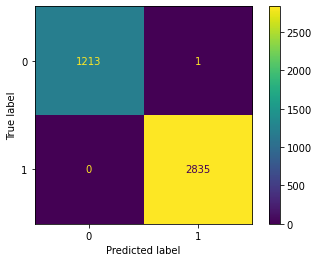

In [62]:
# Create the confusion matrix
predictions = nn.predict(X_test_scaled)
predictions = np.round(predictions).astype(int)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [63]:
# Export our model to HDF5 file
nn.save("ML_Diabetes.h5")